# Classification

In [1]:
from util import get_train_dataset, get_features
from sklearn.ensemble import RandomForestClassifier

df = get_train_dataset()
x = get_features(df)  # contains both alfa and beta features
y = df['reaction']

n_trees = 200

clf = RandomForestClassifier(n_estimators=n_trees, random_state=42, class_weight='balanced', verbose=1)

In [13]:
x.head()

,beta_J,beta_J=TRBJ1-1,beta_J=TRBJ1-1*01,beta_J=TRBJ1-2,beta_J=TRBJ1-2*01,beta_J=TRBJ1-3,beta_J=TRBJ1-3*01,beta_J=TRBJ1-4,beta_J=TRBJ1-4*01,beta_J=TRBJ1-5,...,alfa_pos_8_pI,alfa_pos_0_pI,alfa_pos_-9_pI,alfa_pos_9_pI,alfa_pos_-10_pI,alfa_pos_10_pI,alfa_pos_-11_pI,alfa_pos_11_pI,alfa_pos_-12_pI,alfa_pos_12_pI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.012207,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,6.012207,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,6.012207,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.012207,0.000000,5.253418,6.012207,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.012207,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Search all NaN's in x
import numpy as np

np.sum(np.isnan(x))  # A lot more nan's in alfa (since there is more missing data)
# just use 0 for now
x = x.fillna(0)
assert sum(np.sum(np.isnan(x))) == 0

In [15]:
# print the counts of y
y.value_counts()

1    4162
0    4145
Name: reaction, dtype: int64

In [6]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label, title):
    plt.figure()
    plt.plot(fpr, tpr, color='green', lw=2, label=label)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


def get_training_data_roc_cv(clf, x, y):
    # ROC curve  on the training data
    predictions_rf = cross_val_predict(clf, x, y, cv=2, method="predict_proba")
    fpr, tpr, thresholds = metrics.roc_curve(y, predictions_rf[:, 1], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")
    print(f"ROC AUC: {roc_auc}")


In [ ]:
# TIME: +- 20 min
get_training_data_roc_cv(clf, x, y)

This doesn't seem correct... Let's take a look at the most important features

In [4]:
# TIME: 3.8 min
clf_fitted = clf.fit(x, y)  # takes about 3.8 minutes

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.3min finished


In [15]:
assert 'reaction' not in x.columns  # make sure we don't use the reaction column

# Get the most important features
importances = clf_fitted.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(x.shape[1])[0:10]:
    feature_index = indices[f]
    feature_name = x.columns[feature_index]
    print(f"{f + 1}. feature {feature_index}: {feature_name} ({importances[feature_index]})")

Feature ranking:
1. feature 57: beta_V=TRBV19*01 (0.08862042354957551)
2. feature 26: beta_J=TRBJ2-7*01 (0.04458626892897403)
3. feature 13: beta_J=TRBJ2-1 (0.03345992603380209)
4. feature 14: beta_J=TRBJ2-1*01 (0.03283083244164982)
5. feature 130: beta_CDR3_length (0.025865975169020054)
6. feature 155: beta_peptide_mass (0.023742822738472034)
7. feature 25: beta_J=TRBJ2-7 (0.021023058177938314)
8. feature 18: beta_J=TRBJ2-3*01 (0.01852154007604858)
9. feature 2: beta_J=TRBJ1-1*01 (0.01476732455691582)
10. feature 743: alfa_J=TRAJ42*01 (0.014409235450937374)


In [17]:
# No clear reasons why results are so good, let's create a test set from the training set
# Split x and y in a train and test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# reset clf
clf = RandomForestClassifier(n_estimators=n_trees, random_state=42, class_weight='balanced', verbose=1)
# fit clf
clf_fitted = clf.fit(x_train, y_train)
# predict and calculate roc
predictions_rf = clf_fitted.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_rf[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")
print(f"ROC AUC: {roc_auc}")

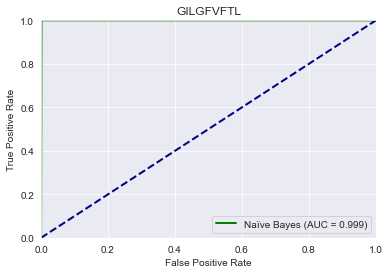

ROC AUC: 0.9994054696789536


In [24]:
# With this accuracy, I would expect naïve bayes to also perform quite good
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf_fitted = clf.fit(x_train, y_train)
# predict and calculate roc
predictions_rf = clf_fitted.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_rf[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Naïve Bayes (AUC = {roc_auc:.3f})', title="GILGFVFTL")
print(f"ROC AUC: {roc_auc}")


Still no clear reason, try splitting train and test set before creating features

In [13]:
from util import get_train_dataset, get_features
from sklearn.model_selection import train_test_split

df = get_train_dataset()

# Split df into train and test set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Get features
x_train = get_features(df_train)
y_train = df_train['reaction']
x_train.fillna(0, inplace=True)

assert x_train.shape[0] == y_train.shape[0]

x_test = get_features(df_test, test=True)
x_test2 = get_features(df_test) # kijken of zelfde als x_test, kijken of ze de verwachte lengte hebben. kijken in literatuur of ander model voor missing dat. Moet sowieso voor m'n thesis literatuur in.

x_test_columns = x_test.columns
x_test2_columns = x_test2.columns
diff_columns = x_test_columns.difference(x_test2_columns)

y_test = df_test['reaction']

x_test.fillna(0, inplace=True)
x_test2.fillna(0, inplace=True)

assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)

Index(['alfa_J=TRAJ10*01', 'alfa_J=TRAJ13*02', 'alfa_J=TRAJ24*02',
       'alfa_J=TRAJ29*01', 'alfa_J=TRAJ3*01', 'alfa_J=TRAJ38*01',
       'alfa_J=TRAJ46*01', 'alfa_J=TRAJ56', 'alfa_J=TRAJ61', 'alfa_J=TRAJ9*01',
       ...
       'beta_V=TRAV8-3*01', 'beta_V=TRAV8-4', 'beta_V=TRAV8-4*01',
       'beta_V=TRAV8-5', 'beta_V=TRAV8-6', 'beta_V=TRAV8-6*01',
       'beta_V=TRAV8-6*02', 'beta_V=TRAV9-2', 'beta_V=TRAV9-2*01',
       'beta_V=TRDV1'],
      dtype='object', length=203)


In [2]:
def fix_missing_columns(train_columns, df):
    # add all columns that are in x to x_test (and fill them with 0's if they weren't in x_test)
    for col in train_columns:
        if col not in df.columns:
            df[col] = 0

    # remove all columns from x_test that are not in x
    x_test = df[x_train.columns]
    return x_test

x_test = fix_missing_columns(x_train.columns, x_test)
x_test2 = fix_missing_columns(x_train.columns, x_test2)

assert x_train.shape[1] == x_test.shape[1]

C:\Users\arnod\AppData\Local\Temp/ipykernel_14260/261172612.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0


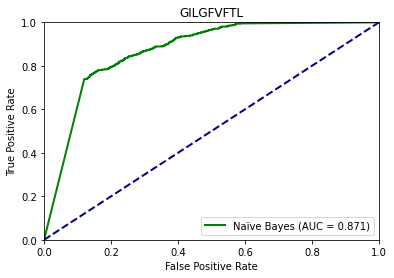

ROC AUC: 0.8708790214074364


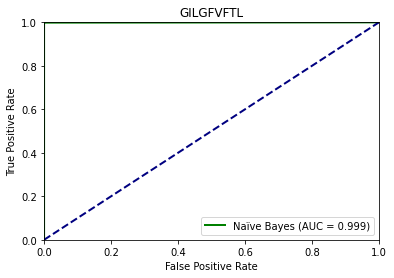

ROC AUC: 0.9993909866017052


In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

# Run naïve bayes
clf = GaussianNB()
clf_fitted = clf.fit(x_train, y_train)

# predict and calculate roc test=True
predictions_rf = clf_fitted.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_rf[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Naïve Bayes (AUC = {roc_auc:.3f})', title="GILGFVFTL")
print(f"ROC AUC: {roc_auc}")

# predict and calculate roc test=False
predictions_rf = clf_fitted.predict_proba(x_test2)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_rf[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Naïve Bayes (AUC = {roc_auc:.3f})', title="GILGFVFTL")
print(f"ROC AUC: {roc_auc}")

In [9]:
# we see that we have an (impossible) almost perfect result for x_test2 (with test=False in generate features), let's take a look at the differences between those two

# Check whether they have the same columns
assert x_test.columns.equals(x_test2.columns)

# Take a random column and see whether it's the same
col = x_test.columns[0]
assert x_test[col].equals(x_test2[col])

# Print the columns that are different
for col in x_test.columns:
    if not x_test[col].equals(x_test2[col]):
        print(col)

beta_J=TRBJ1-1
beta_J=TRBJ1-1*01
beta_J=TRBJ1-2
beta_J=TRBJ1-2*01
beta_J=TRBJ1-3
beta_J=TRBJ1-3*01
beta_J=TRBJ1-4
beta_J=TRBJ1-4*01
beta_J=TRBJ1-5
beta_J=TRBJ1-5*01
beta_J=TRBJ1-6
beta_J=TRBJ1-6*01
beta_J=TRBJ2-1
beta_J=TRBJ2-1*01
beta_J=TRBJ2-2
beta_J=TRBJ2-2*01
beta_J=TRBJ2-3
beta_J=TRBJ2-3*01
beta_J=TRBJ2-4
beta_J=TRBJ2-4*01
beta_J=TRBJ2-5
beta_J=TRBJ2-5*01
beta_J=TRBJ2-6
beta_J=TRBJ2-6*01
beta_J=TRBJ2-7
beta_J=TRBJ2-7*01
beta_V=TRBV10-1*01
beta_V=TRBV10-2
beta_V=TRBV10-3
beta_V=TRBV10-3*01
beta_V=TRBV11-1
beta_V=TRBV11-2
beta_V=TRBV11-2*01
beta_V=TRBV11-3
beta_V=TRBV12-3
beta_V=TRBV12-3*01
beta_V=TRBV12-4
beta_V=TRBV12-4*01
beta_V=TRBV12-5
beta_V=TRBV12-5*01
beta_V=TRBV13
beta_V=TRBV13*01
beta_V=TRBV14
beta_V=TRBV14*01
beta_V=TRBV15
beta_V=TRBV15*01
beta_V=TRBV18
beta_V=TRBV18*01
beta_V=TRBV19
beta_V=TRBV19*01
beta_V=TRBV19*02
beta_V=TRBV2
beta_V=TRBV2*01
beta_V=TRBV20-1
beta_V=TRBV20-1*01
beta_V=TRBV21-1
beta_V=TRBV23-1
beta_V=TRBV24-1
beta_V=TRBV24-1*01
beta_V=TRBV25-1
beta_V=TRB

In [12]:
col = 'beta_J=TRBJ1-1'
# See how much the values differ
x_test_col = x_test[col]
x_test2_col = x_test2[col]

diff_values = x_test_col[x_test_col != x_test2_col]
print(f"Number of different values: {len(diff_values)}/{len(x_test_col)}")

diff_test = x_test_col[x_test_col != x_test2_col]
diff_test2 = x_test2_col[x_test_col != x_test2_col]

# Create one df with the values that are different
import pandas as pd
diff_df = pd.DataFrame({'test': diff_test, 'test2': diff_test2})
diff_df

Number of different values: 96/1662


,test,test2
31,0,1.0
57,0,1.0
105,0,1.0
106,0,1.0
114,0,1.0
...,...,...
1612,0,1.0
1624,0,1.0
1636,0,1.0
1648,0,1.0


In [20]:
# This accuracy should only be possible if reaction is in the features
assert all(['reaction' not in col for col in x_train.columns])
# for column in x_train.columns:
#     print(column)

C:\Users\arnod\AppData\Local\Temp/ipykernel_14260/1883163809.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


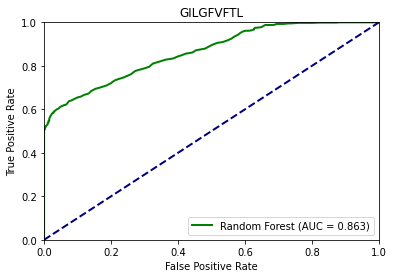

ROC AUC: 0.8630812741111459


C:\Users\arnod\AppData\Local\Temp/ipykernel_14260/1883163809.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


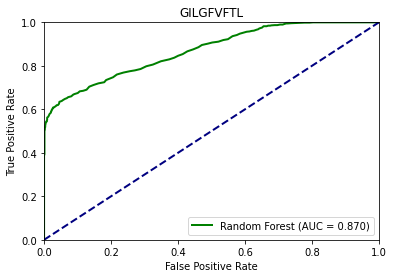

ROC AUC: 0.8699812113045802


C:\Users\arnod\AppData\Local\Temp/ipykernel_14260/1883163809.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


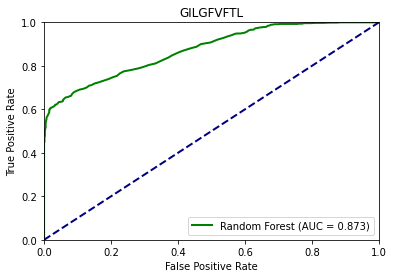

ROC AUC: 0.8734881477737337


C:\Users\arnod\AppData\Local\Temp/ipykernel_14260/1883163809.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


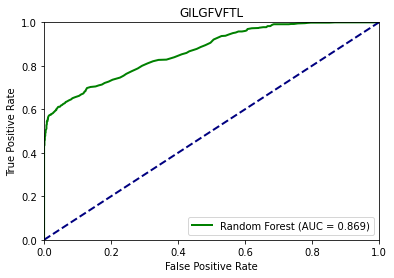

ROC AUC: 0.8690682319053091


C:\Users\arnod\AppData\Local\Temp/ipykernel_14260/1883163809.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


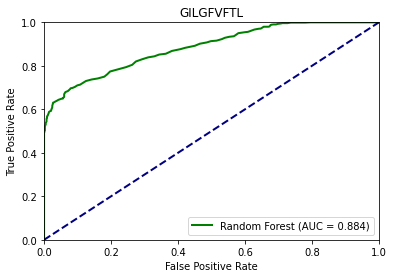

ROC AUC: 0.8837564187060468
Average AUC: 0.8718750567601632 (0.00682003451546648)
AUC list: [0.8630812741111459, 0.8699812113045802, 0.8734881477737337, 0.8690682319053091, 0.8837564187060468]


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import numpy as np

def own_cross_val_predict(clf, df, cv=5):
    predictions_rf = []
    auc_list = []
    for i in range(cv):
        df_train, df_test = train_test_split(df, test_size=0.2)

        x_train = get_features(df_train)
        y_train = df_train['reaction']
        x_train.fillna(0, inplace=True)
        assert x_train.shape[0] == y_train.shape[0]

        x_test = get_features(df_test, test=True)
        y_test = df_test['reaction']
        x_test.fillna(0, inplace=True)
        assert len(x_train) == len(y_train)
        assert len(x_test) == len(y_test)

        # add all columns that are in x to x_test (and fill them with 0's if they weren't in x_test)
        for col in x_train.columns:
            if col not in x_test.columns:
                x_test[col] = 0
        # remove all columns from x_test that are not in x
        x_test = x_test[x_train.columns]
        assert x_train.shape[1] == x_test.shape[1]

        clf_fitted = clf.fit(x_train, y_train)

        predictions = clf_fitted.predict_proba(x_test)
        predictions_rf.append(predictions)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions[:, 1], pos_label=1)
        roc_auc = metrics.auc(fpr, tpr)
        auc_list.append(roc_auc)
        plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")
        print(f"ROC AUC: {roc_auc}")

    # transpose predictions_rf
    predictions_rf = np.array(predictions_rf).T
    print(f"Average AUC: {np.mean(auc_list)} ({np.std(auc_list)})")
    print(f"AUC list: {auc_list}")
    return predictions_rf



# Now create our own version of the cross_val_predict function that uses test = True on the get_features function with test
def own_get_training_data_roc_cv(clf, df):
    # ROC curve  on the training data
    predictions_rf = own_cross_val_predict(clf, df, cv=5)
    # fpr, tpr, thresholds = metrics.roc_curve(y, predictions_rf[:, 1], pos_label=1)
    # roc_auc = metrics.auc(fpr, tpr)
    # plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")
    # print(f"ROC AUC: {roc_auc}")

df = get_train_dataset()
# x = get_features(df)  # contains both alfa and beta features
# y = df['reaction']

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', verbose=1)
# x.fillna(0, inplace=True)
# randomly select 200 rows from the dataset
# df2 = df.sample(n=200, random_state=42)
own_get_training_data_roc_cv(clf, df)

# Test Data

In [2]:
from sklearn.ensemble import RandomForestClassifier

df = get_train_dataset()
x = get_features(df)  # contains both alfa and beta features
y = df['reaction']
x.fillna(0, inplace=True)

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', verbose=1)
clf_fitted = clf.fit(x, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  5.2min finished


In [3]:
# Test data
from util import get_test_dataset

df_test = get_test_dataset()
x_test = get_features(df_test, test=True)
x_test2 = get_features(df_test)

x_test = x_test.fillna(0)
x_test2 = x_test2.fillna(0)

y_test = df_test['reaction']

In [4]:
# add all columns that are in x to x_test (and fill them with 0's if they weren't in x_test)
for col in x.columns:
    if col not in x_test.columns:
        x_test[col] = 0
    if col not in x_test2.columns:
        x_test2[col] = 0
# remove all columns from x_test that are not in x
x_test = x_test[x.columns]
x_test2 = x_test2[x.columns]

# make sure they both have the same number of features
assert x.shape[1] == x_test.shape[1]

C:\Users\arnod\AppData\Local\Temp/ipykernel_49816/3056740009.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0
C:\Users\arnod\AppData\Local\Temp/ipykernel_49816/3056740009.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test2[col] = 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished


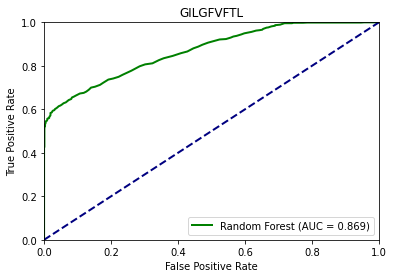

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[1001   46]
 [ 397  633]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


In [7]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt

# ROC curve on the test data
predictions_rf = clf_fitted.predict_proba(x_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_rf[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")

# Also print the confusion matrix
y_pred = clf_fitted.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished


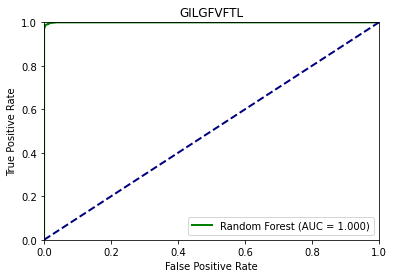

[[1001   46]
 [ 397  633]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt

# ROC curve on the test data
predictions_rf = clf_fitted.predict_proba(x_test2)
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_rf[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="GILGFVFTL")

# Also print the confusion matrix
y_pred = clf_fitted.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))

In [10]:
# Check whether they have the same columns
assert x_test.columns.equals(x_test2.columns)

# # Take a random column and see whether it's the same
# col = x_test.columns[0]
# assert x_test[col].equals(x_test2[col]) # AssertionError, they're not the same

# Print the columns that are different
for col in x_test.columns:
    if not x_test[col].equals(x_test2[col]):
        print(col)

beta_J
beta_J=TRBJ1-1
beta_J=TRBJ1-1*01
beta_J=TRBJ1-2
beta_J=TRBJ1-2*01
beta_J=TRBJ1-3
beta_J=TRBJ1-3*01
beta_J=TRBJ1-4
beta_J=TRBJ1-4*01
beta_J=TRBJ1-5
beta_J=TRBJ1-5*01
beta_J=TRBJ1-6
beta_J=TRBJ1-6*01
beta_J=TRBJ2-1
beta_J=TRBJ2-1*01
beta_J=TRBJ2-2
beta_J=TRBJ2-2*01
beta_J=TRBJ2-3
beta_J=TRBJ2-3*01
beta_J=TRBJ2-4
beta_J=TRBJ2-4*01
beta_J=TRBJ2-5
beta_J=TRBJ2-5*01
beta_J=TRBJ2-6
beta_J=TRBJ2-6*01
beta_J=TRBJ2-7
beta_J=TRBJ2-7*01
beta_V
beta_V=TRBV10-1*01
beta_V=TRBV10-2
beta_V=TRBV10-2*01
beta_V=TRBV10-3
beta_V=TRBV10-3*01
beta_V=TRBV11-1
beta_V=TRBV11-1*01
beta_V=TRBV11-2
beta_V=TRBV11-2*01
beta_V=TRBV11-3
beta_V=TRBV11-3*01
beta_V=TRBV12-3
beta_V=TRBV12-3*01
beta_V=TRBV12-4
beta_V=TRBV12-4*01
beta_V=TRBV12-5
beta_V=TRBV12-5*01
beta_V=TRBV13
beta_V=TRBV13*01
beta_V=TRBV14
beta_V=TRBV14*01
beta_V=TRBV15
beta_V=TRBV15*01
beta_V=TRBV16
beta_V=TRBV18
beta_V=TRBV18*01
beta_V=TRBV19
beta_V=TRBV19*01
beta_V=TRBV19*02
beta_V=TRBV2
beta_V=TRBV2*01
beta_V=TRBV20-1
beta_V=TRBV20-1*01
beta_V=T

In [12]:
col = 'beta_J=TRBJ1-1'
# See how much the values differ
x_test_col = x_test[col]
x_test2_col = x_test2[col]

diff_values = x_test_col[x_test_col != x_test2_col]
print(f"Number of different values: {len(diff_values)}/{len(x_test_col)}")

diff_test = x_test_col[x_test_col != x_test2_col]
diff_test2 = x_test2_col[x_test_col != x_test2_col]

# Create one df with the values that are different
import pandas as pd
diff_df = pd.DataFrame({'test': diff_test, 'test2': diff_test2})
diff_df

Number of different values: 103/2077


,test,test2
2,0,1.0
11,0,1.0
13,0,1.0
119,0,1.0
137,0,1.0
...,...,...
1997,0,1.0
2000,0,1.0
2023,0,1.0
2037,0,1.0
